In [1]:
import os
import sys
import re
from nltk.corpus import stopwords
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

22/04/13 15:08:08 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/13 15:08:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/13 15:08:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/13 15:08:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/13 15:08:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/04/13 15:08:09 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/04/13 15:08:09 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/04/13 15:08:09 WAR

In [3]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [4]:
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/fanfics_raw.csv"))

In [5]:
import nltk
nltk.pos_tag(["Arthur", "loves", "fish"])

[('Arthur', 'NNP'), ('loves', 'VBZ'), ('fish', 'JJ')]

In [6]:
import pyspark.sql.functions as f
data = data.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
data.show()

+--------------------+--------------------+--------------------+--------------------+
|                  id|                text|                type|                line|
+--------------------+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|           Chapter 1|
|Going back was th...| after a case lik...| I’d be moved to ...| after a case lik...|
|It was during my ...| Sophia was no lo...| especially since...| Sophia was no lo...|
|Following Sophia ...| I ducked in an e...| waiting under a ...| I ducked in an e...|
|Aegis breaking in...| but when they ca...| barely managing ...| but when they ca...|
|I hated coming to...|                sure| but everyone her...|                sure|
|             Somehow| this time was ev...| my instincts wer...| this time was ev...|
|The restaurant Li...| just off the Boa...| and without thos...| just off the Boa...|
|I managed to snea...| I tested for spe...| there were

In [7]:
def removeProperNouns(sentence):
    tagged_sentence = nltk.tag.pos_tag(nltk.word_tokenize(sentence))
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    return ' '.join(edited_sentence)

In [8]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))
StopWords = nltk.corpus.stopwords.words("english")
classics = data.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
tokens = classics                                                 \
    .map(lambda document: removeProperNouns(document))             \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])     \
    .zipWithIndex()

In [9]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [10]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [11]:
num_topics = 10
max_iterations = 1000
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/13 15:10:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/13 15:10:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [12]:
data.printSchema()
data.show()

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- line: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                  id|                text|                type|                line|
+--------------------+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|           Chapter 1|
|Going back was th...| after a case lik...| I’d be moved to ...| after a case lik...|
|It was during my ...| Sophia was no lo...| especially since...| Sophia was no lo...|
|Following Sophia ...| I ducked in an e...| waiting under a ...| I ducked in an e...|
|Aegis breaking in...| but when they ca...| barely managing ...| but when they ca...|
|I hated coming to...|                sure| but everyone her...|                sure|
|             Somehow| this time was ev...| my instincts wer...| this time was

In [13]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [14]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[35, 25, 97, 94, ...|[0.02302687412237...|[looking, head, a...|
|    1|[16, 22, 50, 41, ...|[0.03013338401947...|[well, though, te...|
|    2|[12, 14, 43, 58, ...|[0.03476255673375...|[going, right, an...|
|    3|[0, 33, 78, 51, 4...|[0.07145447546812...|[says, look, home...|
|    4|[15, 28, 24, 88, ...|[0.03040997037597...|[little, take, ma...|
|    5|[48, 55, 57, 39, ...|[0.01927171471153...|[feel, looked, ac...|
|    6|[20, 56, 63, 38, ...|[0.01832491232742...|[around, hair, do...|
|    7|[4, 13, 27, 60, 9...|[0.04556675467981...|[know, really, su...|
|    8|[1, 37, 8, 67, 26...|[0.06214125710929...|[said, thought, s...|
|    9|[11, 17, 2, 3, 10...|[0.02849121231918...|[think, good, wou...|
+-----+--------------------+--------------------+--------------------+



In [15]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[35, 25, 97, 94, ...|[0.02302687412237...|looking head asks...|
|    1|[16, 22, 50, 41, ...|[0.03013338401947...|well though tell ...|
|    2|[12, 14, 43, 58, ...|[0.03476255673375...|going right anyth...|
|    3|[0, 33, 78, 51, 4...|[0.07145447546812...|says look home lo...|
|    4|[15, 28, 24, 88, ...|[0.03040997037597...|little take make ...|
|    5|[48, 55, 57, 39, ...|[0.01927171471153...|feel looked actua...|
|    6|[20, 56, 63, 38, ...|[0.01832491232742...|around hair door ...|
|    7|[4, 13, 27, 60, 9...|[0.04556675467981...|know really sure ...|
|    8|[1, 37, 8, 67, 26...|[0.06214125710929...|said thought some...|
|    9|[11, 17, 2, 3, 10...|[0.02849121231918...|think good would ...|
+-----+--------------------+--------------------+--------------------+



In [16]:
df = ldatopics_mapped.withColumn("new", f.arrays_zip("topic_desc", "termWeights"))\
       .withColumn("new", f.explode("new")) \
        .select("topic", f.col("new.topic_desc").alias("words"), f.col("new.termWeights").alias("termWeights"))
df.show()

+-----+-------+--------------------+
|topic|  words|         termWeights|
+-----+-------+--------------------+
|    0|looking|0.023026874122377018|
|    0|   head|0.017117053111685453|
|    0|   asks|0.013762590965507082|
|    0|  looks|0.013533875314089849|
|    0| mother| 0.01266910381767022|
|    0|   okay|0.012667608588610569|
|    0|   face|0.011904353433614833|
|    0|  house|0.011737032961630018|
|    0|  words| 0.01155737647455178|
|    0|   rest|0.011374657231132797|
|    1|   well|0.030133384019473033|
|    1| though|0.026243936151668375|
|    1|   tell|0.018974703916497592|
|    1|  asked|0.018892777177806203|
|    1|  least| 0.01624964003882108|
|    1|  smile|0.014582559041108284|
|    1|quickly| 0.01452513574831788|
|    1| rather|0.012788660840790424|
|    1|   next|0.011523821105690968|
|    1|finally| 0.01096243317379012|
+-----+-------+--------------------+
only showing top 20 rows



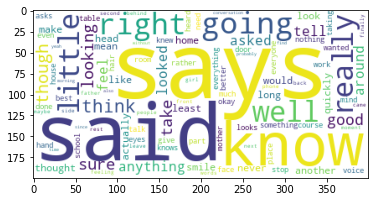

In [17]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*df.select(F.create_map('words', 'termWeights')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()


In [18]:
nltk.pos_tag(["lisa"])

[('lisa', 'NN')]

In [19]:
removeProperNouns("Lisa is me")

'is me'